In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

class OccMatrix():
    def __init__(self, dim=[10,10], occ_space=None, resolution=0.1, origin=[0, 0]):
        """
        Inizializza una matrice di occupazione.
        
        Args:
        - dim: Dimensioni della griglia (larghezza e altezza in metri).
        - free_space: Lista di celle libere (valore = 0).
        - occ_space: Lista di celle occupate (valore = 1).
        - resolution: Risoluzione della mappa (dimensione di una cella in metri).
        - origin: Coordinate mondo dell'origine della mappa (coordinate [0,0] della griglia).
        """
        self.width = int(np.ceil(dim[0]/resolution))
        self.height = int(np.ceil(dim[1]/resolution))
        self.resolution = resolution
        self.origin = origin  # Posizione in coordinate mondo dell'origine (cella [0,0])
        self.shape = [self.height, self.width]  # La forma della griglia (numero di righe, colonne)
        self.data = np.zeros(self.shape, dtype=int)  # Inizializza la griglia con valori liberi

        if occ_space is not None:
            min_cell = self.world_to_grid(occ_space[0], occ_space[1])
            min_row = min_cell[0]
            min_col = min_cell[1]
            
            max_cell = self.world_to_grid(occ_space[2], occ_space[3])
            max_row = max_cell[0]
            max_col = max_cell[1]
            
            for i in range(min_row, max_row + 1, 1):
                for j in range(min_col, max_col + 1, 1):
                    self.set_cell(i, j, 1)
            
    
    def world_to_grid(self, x, y):
        """
        Converte le coordinate mondo (x, y) in coordinate griglia (riga, colonna).
        
        Args:
        - x, y: Coordinate mondo.
        
        Returns:
        - [riga, colonna]: Coordinate della griglia.
        """
        colonna = int((x - self.origin[0]) / self.resolution)
        riga = int((y - self.origin[1]) / self.resolution)
        return [riga, colonna]

    def grid_to_world(self, i, j):
        """
        Converte le coordinate griglia (riga, colonna) in coordinate mondo (x, y).
        
        Args:
        - i, j: Coordinate griglia.
        
        Returns:
        - [x, y]: Coordinate mondo del centro della cella.
        """
        # Calcola le coordinate del centro della cella (i, j)
        x = self.origin[0] + (j + 0.5) * self.resolution
        y = self.origin[1] + (i + 0.5) * self.resolution
        return [x, y]

    def set_cell(self, riga, colonna, value):
        """
        Imposta il valore di una cella nella matrice di occupazione.
        
        Args:
        - riga, colonna: Coordinate della cella nella griglia.
        - value: Valore da impostare (0 = libero, 1 = occupato, -1 = sconosciuto).
        """
        if 0 <= riga < self.height and 0 <= colonna < self.width:
            self.data[riga, colonna] = value

    def get_cell(self, riga, colonna):
        """
        Ottiene il valore di una cella nella matrice di occupazione.
        
        Args:
        - riga, colonna: Coordinate della cella nella griglia.
        
        Returns:
        - Valore della cella (0 = libero, 1 = occupato, -1 = sconosciuto).
        """
        if 0 <= riga < self.height and 0 <= colonna < self.width:
            return self.data[riga, colonna]
        else:
            return None  # Coordinate fuori dalla mappa

def update_tree(tree, state, parent, path):
    N = len(tree)
    cost = 0
    if len(path) > 0:
        curr_position = path[0][:2]
        
        for i in range(1, len(path)):
            next_position = path[i][:2]
            cost += np.linalg.norm(curr_position - next_position)
            curr_position = next_position
        
        
    tree[N] = {'state': state, 'parent': parent, 'cost': cost, 'path': path}

def generate_random_state(R, curr_state, workspace, map):

    Cx = curr_state[0]
    Cy = curr_state[1]
    
    sample_found = False

    while not sample_found:
        alpha = 2 * np.pi * np.random.rand()
        r = R * np.sqrt(np.random.rand())
        x = r * np.cos(alpha) + Cx
        y = r * np.sin(alpha) + Cy
        
        if boundary_check(workspace, x, y):
            cell = map.world_to_grid(x,y)
            
            if map.get_cell(cell[0], cell[1]) == 0:
                sample_found = True

    return np.array([x, y])


def find_nearest_node(sample, tree):
    
    N = len(tree)
    distances = np.zeros(N)
    for i in range(N):
        node_state = tree[i]['state']
        distances[i] = np.linalg.norm(sample[:2] - node_state[:2])
    nearest_id = int(np.argmin(distances))
    nearest_state = tree[nearest_id]['state']
    
    return nearest_id, nearest_state

def wrapToPi(angle):
    """
    Converte l'angolo di input nell'intervallo [-pi, pi].
    Parametri:
        angle (float): L'angolo di input da convertire in radianti
    Ritorna:
        float: L'angolo convertito nell'intervallo [-pi, pi].
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

def boundary_check(workspace, x, y):
    
    if workspace[0] <= x <= workspace[2] and workspace[1] <= y <= workspace[3]:
        return True
    return False
    
def generate_new_node(nearest_state, sample, T_max, unicycle_params, map, workspace):
    v_max = unicycle_params['v_max']
    omega_max = unicycle_params['omega_max']
    K_omega = unicycle_params['K_omega']
    dt = unicycle_params['dt']

    x, y, theta = nearest_state

    path_to_node = np.array(nearest_state)
    min_distance = v_max * dt

    node_found = False
    new_node = nearest_state
    
    for t in np.arange(0, T_max, dt):
        distance_from_node = np.linalg.norm(sample[:2] - np.array([x,y]))
        
        if distance_from_node <= min_distance:
            new_node = np.array([x, y, theta])
            # print('min distance')
            return new_node, path_to_node, node_found

        theta_des = np.atan2(sample[1] - y, sample[0] - x)
        theta_diff = wrapToPi(theta - theta_des)

        omega = - K_omega * theta_diff
        
        if omega > omega_max:
            omega = omega_max
        elif omega < - omega_max:
            omega = - omega_max

        x += v_max*np.cos(theta)*dt
        y += v_max*np.sin(theta)*dt
        theta = wrapToPi(theta + omega*dt)

        if not boundary_check(workspace, x, y):
            # print('out of bounds')
            return np.array([]), np.array([]), False
            
        cell = map.world_to_grid(x, y)
        
        if map.get_cell(cell[0], cell[1]) == -1 or map.get_cell(cell[0], cell[1]) == 1:
            # print('occ cell')
            return np.array([]), np.array([]), False

        path_to_node = np.vstack([path_to_node, np.array([x, y, theta]) ])
        node_found = True

    new_node = np.array([x, y, theta])
    # print('correct path')
    return new_node, path_to_node, node_found

def find_total_path(tree, node_id):
    total_path = np.array([])
    while node_id != 0:
        parent_id = tree[node_id]['parent']
        path_to_node = tree[node_id]['path']
        
        if len(total_path) == 0:
            total_path = path_to_node
        else:
            total_path = np.vstack([path_to_node, total_path])
        node_id = parent_id

    return total_path

In [36]:
workspace = [0,0,10,10] # xmin ymin xmax ymax        
occ_space = [4,4,6,6]

# Genero OccMatrix
map = OccMatrix(dim=[10,10], occ_space=occ_space)

start = np.array([1,1,0], dtype=float)
goal = np.array([9,9,np.pi/2], dtype=float)
R = 3.0

max_iters = 5000
samples = []
T_max = 0.5
goal_tol = 0.5

v_max = 1
omega_max = 5
K_omega = 2
dt = 0.01

unicycle_params = {'v_max': v_max, 'omega_max': omega_max, 'K_omega': K_omega, 'dt': dt}
tree = {}

update_tree(tree, start, -1, np.array([]))

for i in range(100):
    sample = generate_random_state(R, start, workspace, map)
    nearest_id, nearest_state = find_nearest_node(sample, tree)
    new_node, path_to_node, node_found = generate_new_node(nearest_state, sample, T_max, unicycle_params, map, workspace)
    if node_found:
        update_tree(tree, new_node, nearest_id, path_to_node)

tot_path = find_total_path(tree, len(tree)-1)

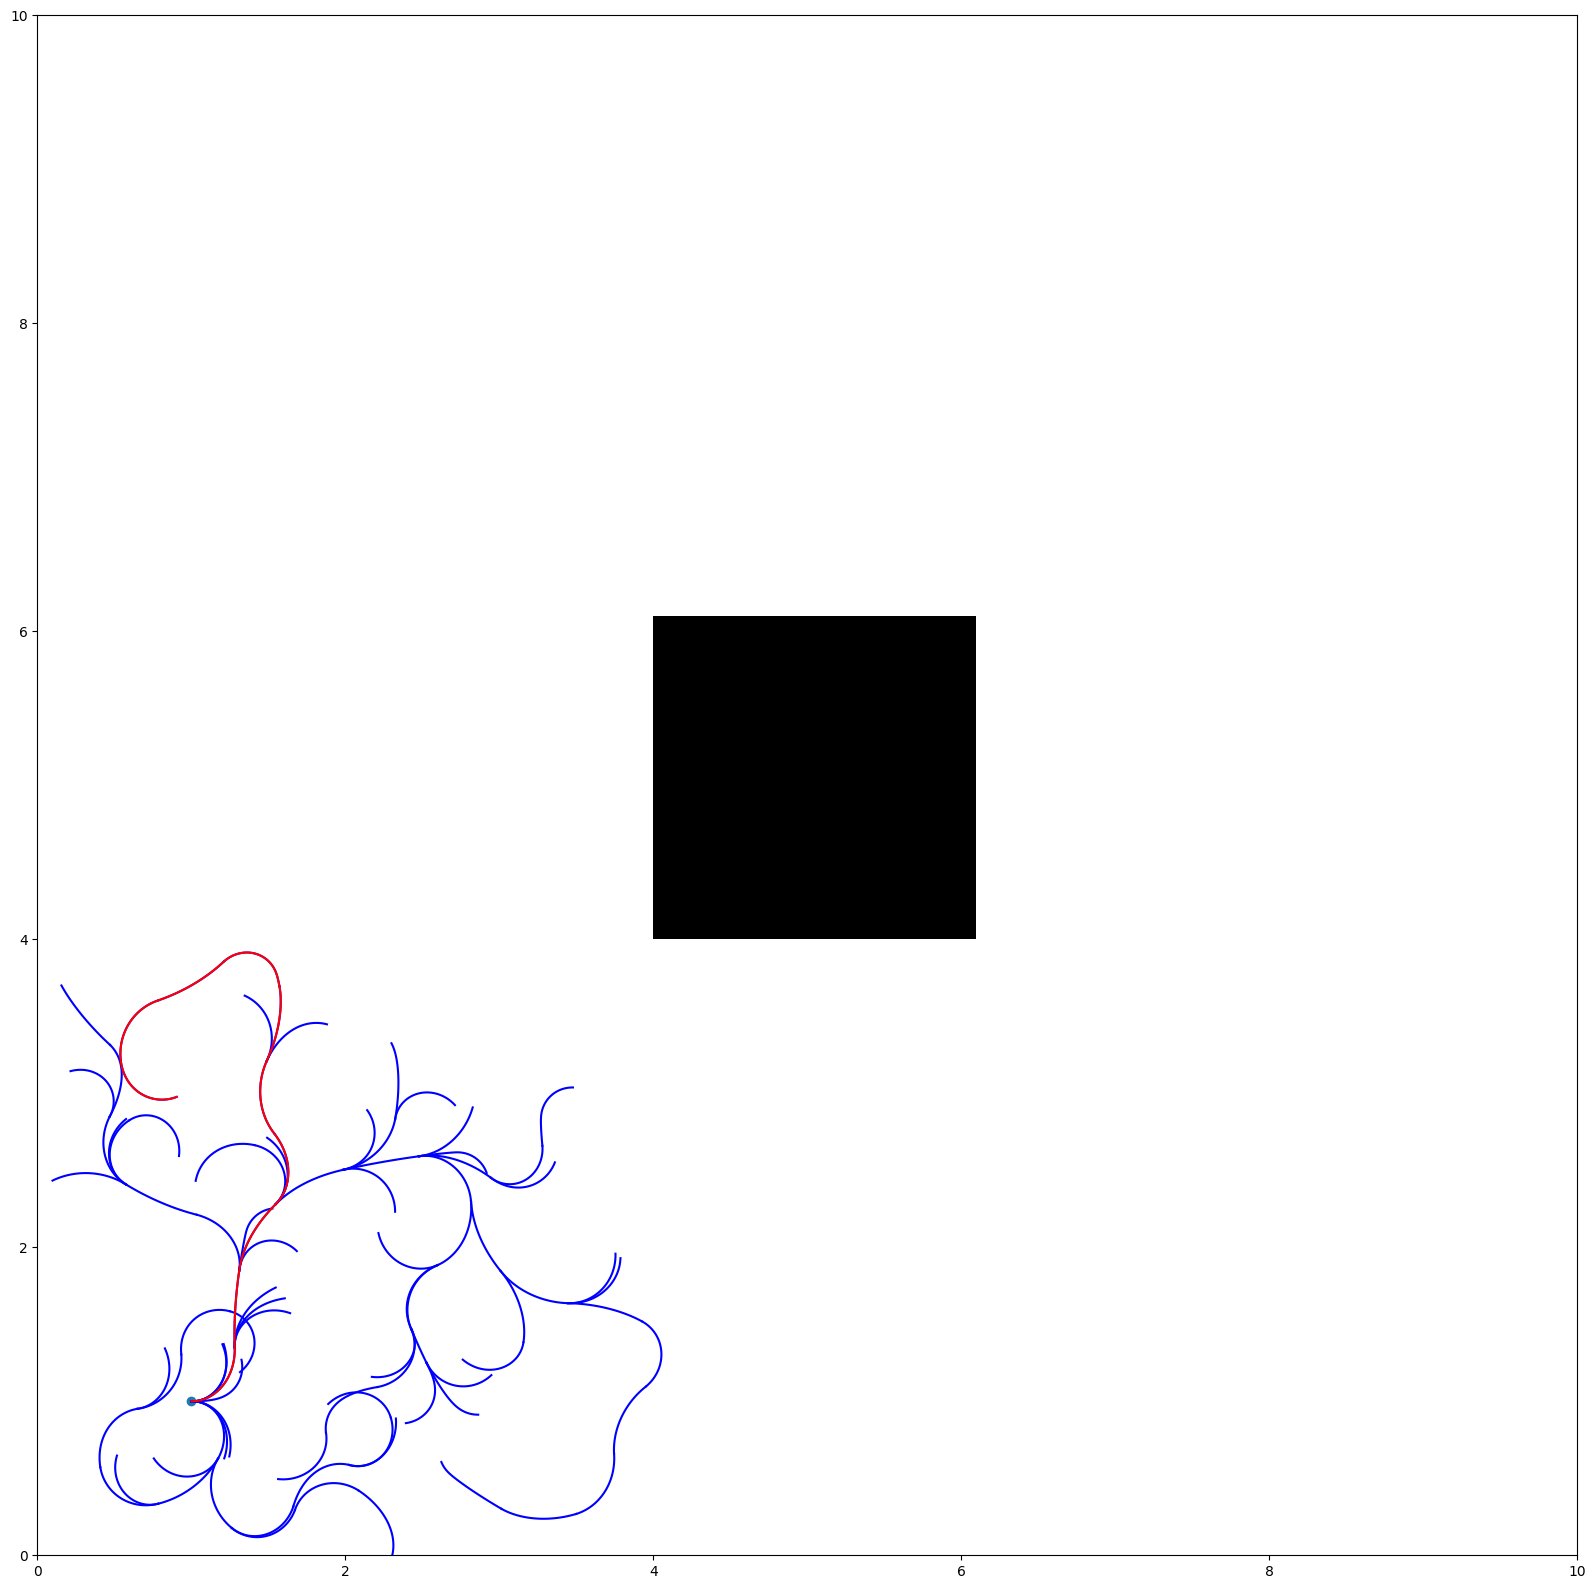

In [37]:
# Creare la colormap: grigio (sconosciuto), bianco (libero), nero (occupato)
plt.figure(figsize=(20,20))
cmap = colors.ListedColormap(['gray', 'white', 'black'])
bounds = [-1.5, -0.5, 0.5, 1.5]  # Limiti per i valori: -1 (sconosciuto), 0 (libero), 1 (occupato)
norm = colors.BoundaryNorm(bounds, cmap.N)

# Calcolare l'estensione della mappa in coordinate del mondo
extent = [
    map.origin[0],  # Estensione asse X: dall'origine fino alla larghezza in metri
    map.origin[0] + map.width * map.resolution,
    map.origin[1],  # Estensione asse Y: dall'origine fino all'altezza in metri
    map.origin[1] + map.height * map.resolution
]

# Plottare la matrice di occupazione
plt.imshow(map.data, cmap=cmap, norm=norm, origin='lower', extent=extent)
plt.scatter(start[0], start[1])

for i in range(1, len(tree)):
    path = tree[i]['path']
    x = [sample[0] for sample in path]
    y = [sample[1] for sample in path]
    plt.plot(x, y, color='blue')
    
x = [pose[0] for pose in tot_path]
y = [pose[1] for pose in tot_path]
plt.plot(x,y, color='red')